In [1]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import List

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.predict import *

## External Dataset

In [84]:
datadir_path = r"../data/input"
config_path = r"../experiments/training/test_failed_flag/config_proT_dyconex_v5_1.yaml"
checkpoint_path = r"../experiments/training/test_failed_flag/k_0/checkpoints/best_checkpoint.ckpt"
# config_path = r"../experiments/training/test_PINN/config_proT_dyconex_v5_1.yaml"
# checkpoint_path = r"../experiments/training/test_PINN/k_0/checkpoints/best_checkpoint.ckpt"

external_dataset =  {
    "dataset":"ds_dx_pred_panel_MSI_01_01_2022-07_07_2025",
    "filename_input": "X.npy",
    "filename_target": "Y.npy",
}

config = OmegaConf.load(config_path)
input_array, output_array, target_array, cross_att_array = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    external_dataset,
    dataset_label="all",
    cluster=False
    )

Global seed set to 42


All data selected (default).
Predicting...


100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


In [85]:
# files
dataset_name = external_dataset["dataset"][3:]
builds_dir = "../../process_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_trg")
var_vocab_input_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_input")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
group_vocab_filepath = join(builds_dir, dataset_name, "output/batch_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(var_vocab_input_filepath, 'r', encoding='utf-8') as file:
    inv_var_input_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
with open(group_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_group_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
var_input_map = {v: k for k, v in inv_var_input_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
group_map = {v: k for k, v in inv_group_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()


# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

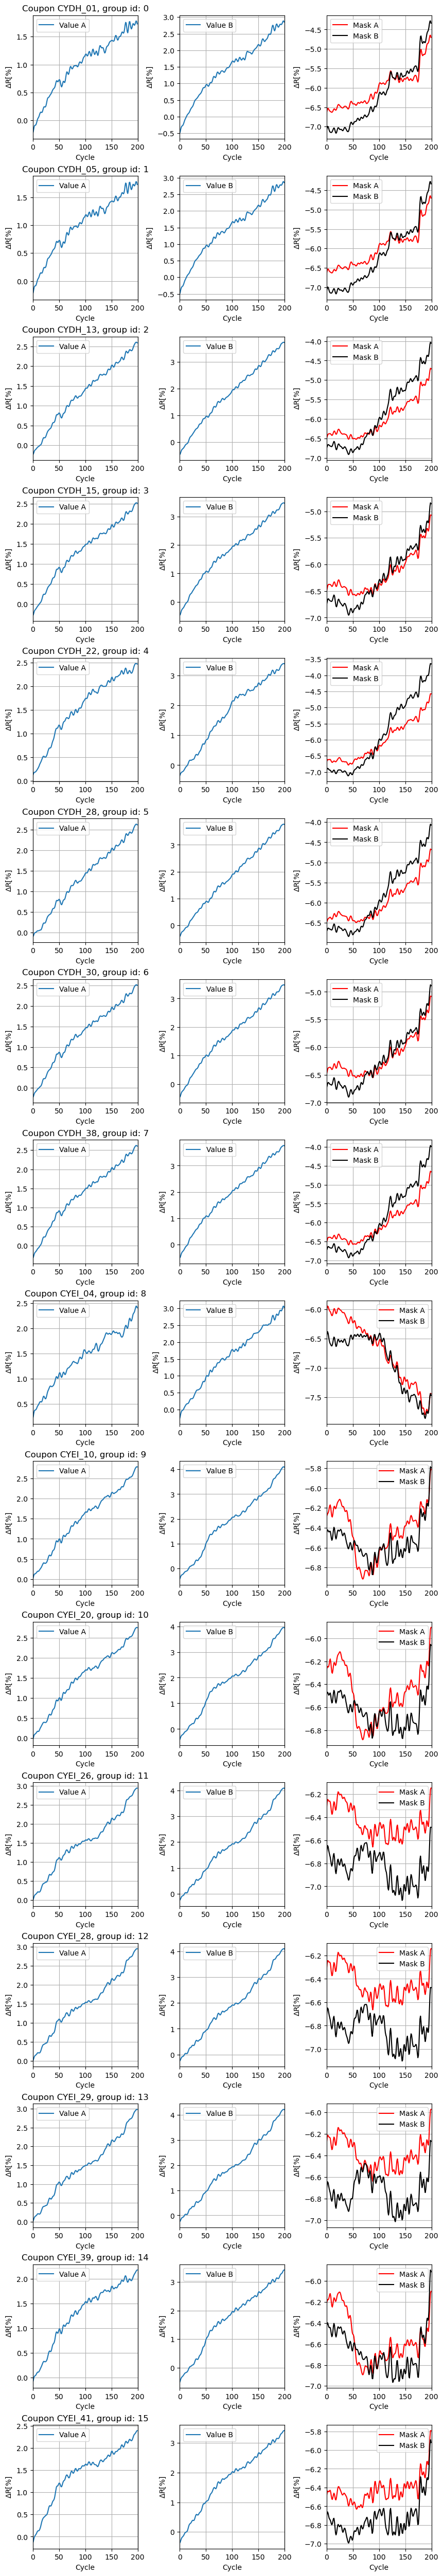

In [87]:
plot_target = False
n_samples = len(output_array)

if len(output_array.shape) == 2:
    pred_value = output_array
    pred_mask = None
else:
    pred_value = output_array[:,:,0]
    pred_mask = output_array[:,:,1]

fig = plt.figure(figsize=(10,n_samples*4))

g = gridspec.GridSpec(
    nrows=n_samples,
    ncols=3,
    hspace=.3,
    wspace=.4
)
for i in range(n_samples):
    ax_val_A = fig.add_subplot(g[i,0])
    ax_val_B = fig.add_subplot(g[i,1])
    ax_m = fig.add_subplot(g[i,2])
    # prediction
    
    # Sense A
    ax_val_A.plot(pred_value[i,:200]*10, label="Value A")
    if plot_target:
        ax_val_A.plot(target_array[i,:200,4]*10, label="target A")
    
    
    # Find breaking region Sense A
    if pred_mask is not None:
        boolean_array = pred_mask[i,:200] > 0
        start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
        if np.size(start_indices)==0:
            start_indices=200
        else:
            start_indices = start_indices.item()
        ax_val_A.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    # Sense B
    ax_val_B.plot(pred_value[i,200:]*10, label="Value B")
    if plot_target:
        ax_val_B.plot(target_array[i,200:,4]*10, label="target B")
    
    # Find breaking region Sense B
    if pred_mask is not None:
        boolean_array = pred_mask[i,200:] > 0
        start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
        if np.size(start_indices)==0:
            start_indices=200
        else:
            start_indices = start_indices.item()
        ax_val_B.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    
    if pred_mask is not None:
        ax_m.plot(pred_mask[i,:200], label="Mask A", color="red")
        ax_m.plot(pred_mask[i,200:], label="Mask B", color = "black")
    
    coupon_group_id = target_array[i,0,0]
    
    ax_val_A.set_title(f"Coupon {group_map[coupon_group_id]}, group id: {int(coupon_group_id)}")
    for ax in [ax_val_A, ax_val_B, ax_m]:
        ax.legend()
        ax.grid(True)
        ax.set_ylabel(r"$\Delta$R[%]")
        ax.set_xlabel("Cycle")
        ax.set_xlim(0,200)

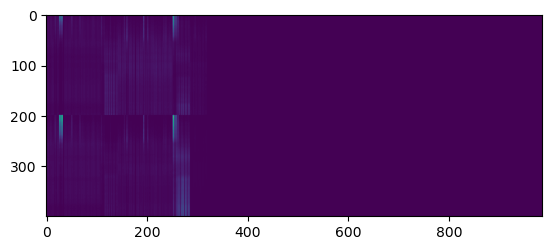

In [5]:
cumul_att = cross_att_array.sum(1)

plt.imshow(cross_att_array.sum(1)[1,:,:])

In [88]:
input_array, output_array, target_array, cross_att_array = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    external_dataset=None,
    dataset_label="test",
    cluster=False
    )
print(f"predicted {len(output_array)} curves!")

Global seed set to 42
c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.0.3
  rank_zero_warn(


Test dataset selected (default).
Predicting...


100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


predicted 4 curves!


In [89]:
# files
dataset_name = "dx_250806_panel_200_pad"  #config["data"]["dataset"][3:]
print(dataset_name)
builds_dir = "../../process_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_trg")
var_vocab_input_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_input")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
group_vocab_filepath = join(builds_dir, dataset_name, "output/batch_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(var_vocab_input_filepath, 'r', encoding='utf-8') as file:
    inv_var_input_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
with open(group_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_group_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
var_input_map = {v: k for k, v in inv_var_input_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
group_map = {v: k for k, v in inv_group_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()


# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

dx_250806_panel_200_pad


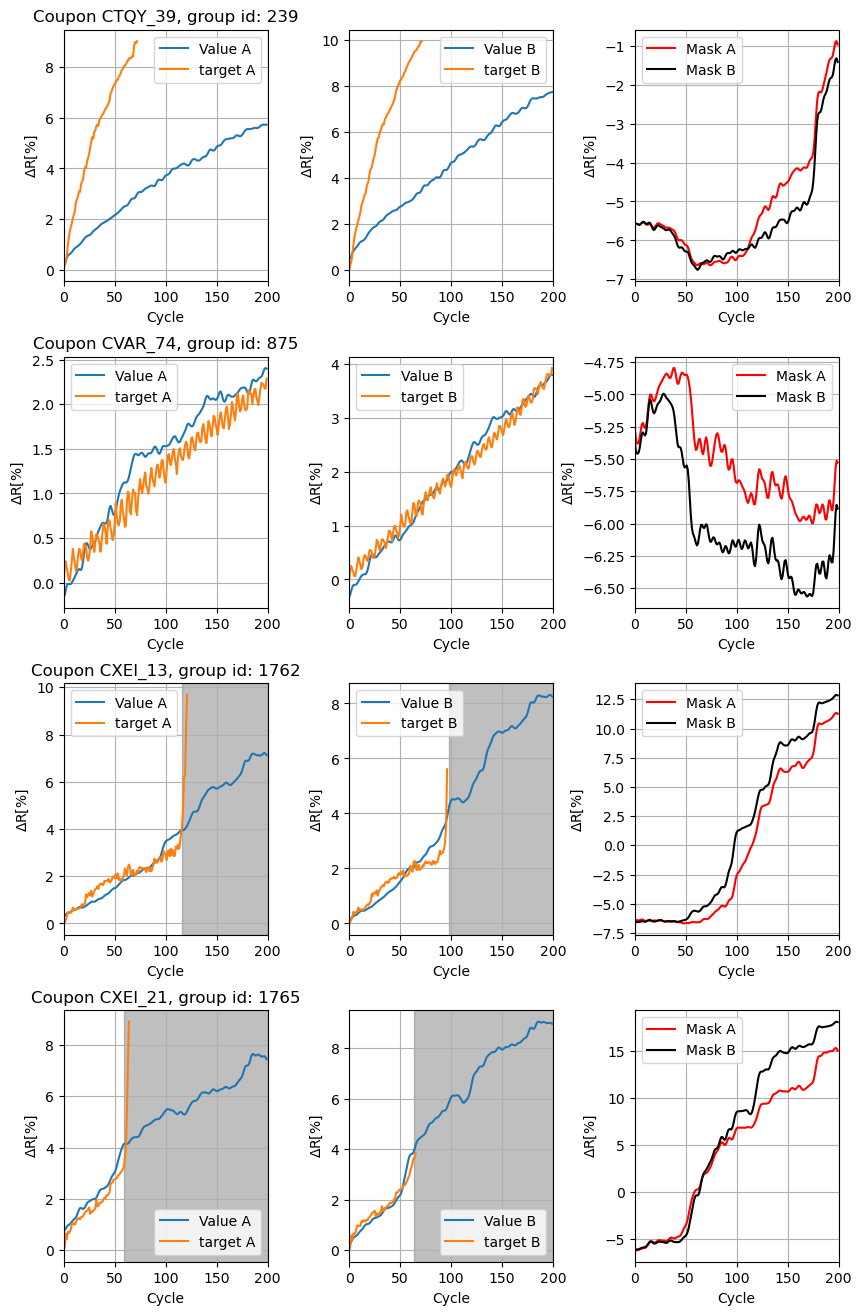

In [91]:
plot_target = True
n_samples = len(output_array)
vars = np.delete(np.unique(np.nan_to_num(target_array[:,:,2])),0)

fig = plt.figure(figsize=(10,n_samples*4))

g = gridspec.GridSpec(
    nrows=n_samples,
    ncols=3,
    hspace=.3,
    wspace=.4
)
for i in range(n_samples):
    ax_val_A = fig.add_subplot(g[i,0])
    ax_val_B = fig.add_subplot(g[i,1])
    ax_m = fig.add_subplot(g[i,2])
    # prediction
    
    ax_val_A.plot(output_array[i,:200,0]*10, label="Value A")
    if plot_target:
        ax_val_A.plot(target_array[i,:200,4]*10, label="target A")
    
    
    # Find breaking region Sense A
    boolean_array = output_array[i,:200,1] > 0
    start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
    if np.size(start_indices)==0:
        start_indices=200
    else:
        start_indices = start_indices.item()
    ax_val_A.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    ax_val_B.plot(output_array[i,200:,0]*10, label="Value B")
    if plot_target:
        ax_val_B.plot(target_array[i,200:,4]*10, label="target B")
    
    # Find breaking region Sense B
    boolean_array = output_array[i,200:,1] > 0
    start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
    if np.size(start_indices)==0:
        start_indices=200
    else:
        start_indices = start_indices.item()
    ax_val_B.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    
    ax_m.plot(output_array[i,:200,1], label="Mask A", color="red")
    ax_m.plot(output_array[i,200:,1], label="Mask B", color = "black")
    
    coupon_group_id = target_array[i,0,0]
    
    ax_val_A.set_title(f"Coupon {group_map[coupon_group_id]}, group id: {int(coupon_group_id)}")
    for ax in [ax_val_A, ax_val_B, ax_m]:
        ax.legend()
        ax.grid(True)
        ax.set_ylabel(r"$\Delta$R[%]")
        ax.set_xlabel("Cycle")
        ax.set_xlim(0,200)
    
    
    
    

# Input Analysis

In [113]:
for i in range(n_samples):
    print(sum(np.isnan(input_array[i,:,4]))/len((input_array[i,:,4]))*100)

42.01954397394137
55.80890336590662
19.76112920738328
11.074918566775244
